# Instalamos la API de Kaggle

Para evitar la descarga local del archivo, realizaremos unos pasos aprovechando la API de Kaggle

In [24]:
!pip install -q kaggle
!mkdir -p ~/.kaggle

Importamos el `kaggle.json` con `google.colab`

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!cp kaggle.json ~/.kaggle/ # Para que el archivo .json quede en la carpeta adecuada para ser leída durante la descarga de datos

# Descargamos el Dataset de Fruits
 
Descargamos y Descomprimimos el dataset que está comprimido 

In [26]:
!kaggle datasets download -d moltean/fruits --force

 99% 1.28G/1.28G [00:37<00:00, 45.8MB/s]
100% 1.28G/1.28G [00:37<00:00, 36.5MB/s]


In [27]:
!unzip /content/fruits.zip -d fruits-360

Archive:  /content/fruits.zip
replace fruits-360/fruits-360-original-size/fruits-360-original-size/Meta/apple_6/info.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Importamos las Librerías Necesarias

In [50]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.optimizers import *
from sklearn.datasets import load_files

import matplotlib.image as mpimg
import numpy as np

import matplotlib.pyplot as plt
from keras.utils import np_utils

# Preparamos los datos para trabajar

Rutas de los directorios

In [ ]:
TRAIN_PATH = "/content/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/"
TEST_PATH = "/content/fruits-360/fruits-360-original-size/fruits-360-original-size/Test/"
VAL_PATH = "/content/fruits-360/fruits-360-original-size/fruits-360-original-size/Validation/"

## Cargamos los datos y dividimos el conjunto de datos en entrenamiento y de prueba con nombres de las etiquetas

- Estamos cargando todos los datos de entrenamiento (train) y prueba (test)
- Guardamos entradas/imágenes en **X_train** de datos de entrenamiento y guardar etiquetas en **Y_train**
- Guardamos entradas/imágenes en **X_test** de datos de prueba y guardar etiquetas en **Y_test**

In [ ]:
def load_dataset(data_path):
    data_loading = load_files(data_path)
    files_add = np.array(data_loading['filenames'])
    targets_fruits = np.array(data_loading['target'])
    target_labels_fruits = np.array(data_loading['target_names'])
    return files_add,targets_fruits,target_labels_fruits
    
X_train, Y_train, target_labels = load_dataset(TRAIN_PATH)
X_test, Y_test, target_labels = load_dataset(TEST_PATH)
X_val, Y_val, target_labels = load_dataset(VAL_PATH)

print('Cantidad de Datos de Entrenamiento: ' , X_train.shape[0])
print('Cantidad de Datos de Validación: ' , X_val.shape[0])
print('Cantidad de Datos de Test: ', X_test.shape[0])
print("Las clases de frutas son: \n", target_labels)

Cantidad de Datos de Entrenamiento:  6231
Cantidad de Datos de Validación:  3114
Cantidad de Datos de Test:  3110
Las clases de frutas son: 
 ['apple_6' 'apple_braeburn_1' 'apple_crimson_snow_1' 'apple_golden_1'
 'apple_golden_2' 'apple_golden_3' 'apple_granny_smith_1' 'apple_hit_1'
 'apple_pink_lady_1' 'apple_red_1' 'apple_red_2' 'apple_red_3'
 'apple_red_delicios_1' 'apple_red_yellow_1' 'apple_rotten_1'
 'cabbage_white_1' 'carrot_1' 'cucumber_1' 'cucumber_3'
 'eggplant_violet_1' 'pear_1' 'pear_3' 'zucchini_1' 'zucchini_dark_1']


## Clases de frutas

Hay 24  etiquetas/clases que son los nombres de frutas ya que estamos usando  de 24 tipos de frutas.

In [29]:
num_classes = len(np.unique(Y_train))
print(f"La cantidad de clases de frutas son: {num_classes}")

La cantidad de clases de frutas son: 2


## Limpieza de datos
Vector del primer registro de Y_train:

- Como sabemos que estamos usando 24 clases/etiquetas, creamos un vector de 24 valores. 
- Podemos ver que solo hay 1 y todos son ceros que muestra una label de la primera imagen.

In [30]:
Y_train = np_utils.to_categorical(Y_train, num_classes)
Y_test = np_utils.to_categorical(Y_test, num_classes)
# Standariza los datos de las dimensiones que tenemos con las 24 posibles opciones 

In [ ]:
Y_train[0] #Ejemplo de la imagen de la posicion 0

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

# Dividir el conjunto de validación en conjunto de prueba y validación.

- Estamos dividiendo los **datos de prueba** (test) en **datos de validación**. 

- Los **datos de validación** se usarán mientras se entrena el modelo para comprobar el rendimiento durante el entrenamiento

- Los **datos de prueba** se usarán después de entrenar el modelo.

In [ ]:
X_test, X_val, Y_test, Y_val=train_test_split(X_test, Y_test, test_size=0.2, random_state=42)
print (f"Los datos de la Validacion son X_val: {X_val.shape} y de Y_val: {Y_val.shape}")
print (f"Los datos del Test son X_test: {X_test.shape} y de Y_test: {Y_test.shape}")

Los datos de la Validacion son X_val: (622,) y de Y_val: (622, 24)
Los datos del Test son X_test: (2488,) y de Y_test: (2488, 24)


# Procesamiento de la Imagen

Definimos como variables globales al numero de clases, el ancho y largo de largo de la imagen y el tamaño de filtro que vamos a utilizar.

In [ ]:
NUM_CLASS = num_classes
IMG_H, IMG_W = 100, 100 
BATCH_SIZE = 32

## Data Augmentation

Usamos el Data Augmentation para tener la imagen con distintas caracteristicas sin modificar el dato. 

In [40]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest",
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

val_generator = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.


# Redes Neuronales Convolucionales

Ahora, comencemos con nuestro primer enfoque que utiliza redes neuronales convolucionales personalizadas. 

Las CNN son técnicas asombrosas que ayudan a una red neuronal a aprender características espaciales y relacionadas. 

Las CNN ayudan a la red neuronal a aprender las relaciones entre varias áreas de una imagen, como bordes, ojos, etc.

Cuanto más profunda es la red neuronal, más características complejas se aprenden.

In [41]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = 3, padding='same', input_shape= (IMG_H, IMG_W, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 32, kernel_size = 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = 3, padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(filters = 64, kernel_size = 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASS))
model.add(Activation('softmax'))


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 activation_12 (Activation)  (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 activation_13 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                  

In [42]:
X_test, X_val, Y_test, Y_val = train_test_split(
    X_test, Y_test, test_size=0.2, random_state=42
)
print(f"Los datos de la Validacion son X_val: {X_val.shape} y de Y_val: {Y_val.shape}")
print(f"Los datos del Test son X_test: {X_test.shape} y de Y_test: {Y_test.shape}")

Los datos de la Validacion son X_val: (255,) y de Y_val: (255, 24, 2)
Los datos del Test son X_test: (1018,) y de Y_test: (1018, 24, 2)


# Compilación de los modelos

- Primero llamamos al modelo

- Estamos usando 24 clases, por lo que establecemos la **pérdida**(lost) como `categorical_crossentropy`. Usamos la **pérdida** como `binary_crossentropy` para dos clases. 

- **Optimizer** es una función que solía cambiar las características de la red neuronal, como la tasa de aprendizaje (cómo aprende el modelo con características) para reducir las pérdidas. Entonces, la tasa de aprendizaje de la red neuronal para reducir las pérdidas está definida por el **optimizador**. 

- Estamos configurando **metrics = accuracy** porque vamos a calcular el porcentaje de predicciones correctas sobre todas las predicciones en el conjunto de validación.


In [43]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

# Entrenamiento del modelo con ajuste de parámetros: 

Estamos alimentando los datos de entrenamiento y los datos de validación para comenzar el entrenamiento del modelo. 

Establecemos los siguientes parámetros:
  - Batch size:  para que el modelo tome 32 imágenes en cada iteración y las entrene. El **batch size** es un término utilizado en el aprendizaje automatizado y se refiere a la cantidad de ejemplos de entrenamiento utilizados en una iteración. 
  - Epochs = 10 (épocas), por lo que el modelo se entrenará con los datos 10 veces. Época es un término que se usa en el aprendizaje automatizado e indica la cantidad de pasadas del conjunto de datos de entrenamiento completo que ha completado el algoritmo. 
  
Podemos elegir el **batch size** y las **epochs** que queramos, por lo que la buena práctica es establecer algunos valores y entrenar el modelo, si el modelo no da los buenos resultados, podemos cambiarlo y luego intentarlo nuevamente para el entrenamiento del modelo. 
 
Podemos repetir este proceso muchas veces hasta que no obtengamos los buenos resultados y este proceso se denomina **ajuste de parámetros**.

## Callbacks

In [45]:
checkpoint = ModelCheckpoint("fruits_cnn.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
callbacks = [checkpoint]

## Entrenamiento

In [46]:
epochs = 10

history = model.fit(
    train_generator,
    batch_size=32,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_generator,
    verbose=2,
    shuffle=True,
)

Epoch 1/10

Epoch 1: val_loss improved from inf to 1.09940, saving model to fruits_cnn.h5
195/195 - 175s - loss: 2.0537 - accuracy: 0.2977 - val_loss: 1.0994 - val_accuracy: 0.5918 - 175s/epoch - 897ms/step
Epoch 2/10

Epoch 2: val_loss improved from 1.09940 to 0.47814, saving model to fruits_cnn.h5
195/195 - 168s - loss: 1.0809 - accuracy: 0.5999 - val_loss: 0.4781 - val_accuracy: 0.8215 - 168s/epoch - 860ms/step
Epoch 3/10

Epoch 3: val_loss improved from 0.47814 to 0.47338, saving model to fruits_cnn.h5
195/195 - 167s - loss: 0.6495 - accuracy: 0.7567 - val_loss: 0.4734 - val_accuracy: 0.8086 - 167s/epoch - 857ms/step
Epoch 4/10

Epoch 4: val_loss did not improve from 0.47338
195/195 - 168s - loss: 0.4739 - accuracy: 0.8281 - val_loss: 0.6334 - val_accuracy: 0.7665 - 168s/epoch - 864ms/step
Epoch 5/10

Epoch 5: val_loss improved from 0.47338 to 0.10740, saving model to fruits_cnn.h5
195/195 - 170s - loss: 0.3895 - accuracy: 0.8623 - val_loss: 0.1074 - val_accuracy: 0.9547 - 170s/epo

#  Visualización de la pérdida y precisión con respecto a las épocas

Estamos mirando la historia del modelo de cada época mientras entrenamos nuestro modelo en 10 épocas.

- La línea azul muestra la precisión del entrenamiento y también la pérdida de entrenamiento.

- La línea naranja muestra la precisión de la prueba y también la pérdida de la prueba.

- La precisión y la pérdida en el entrenamiento y los datos de prueba comienzan desde cero y finalmente cerca de 1 (100%).

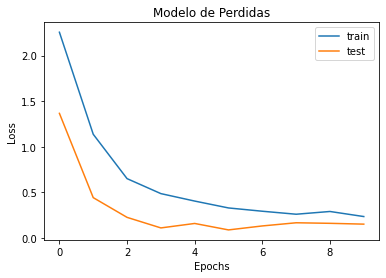

In [ ]:
N = epochs

plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"],label="val_loss")
plt.title("Modelo de Perdidas")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train', 'test'])
plt.show();

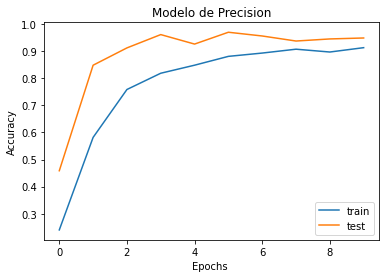

In [ ]:
plt.plot(np.arange(0, N), history.history["accuracy"], label="accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Modelo de Precision")
plt.xlabel("Epochs ")
plt.ylabel("Accuracy")
plt.legend(['train', 'test']);
plt.show();

# Predecir los resultados

- La precisión es el número de imágenes reconocidas correctamente de todas las imágenes.

- Por ejemplo, si el modelo entrenado reconoce 90 imágenes correctas y 10 imágenes incorrectas de un total de 100 imágenes, la puntuación de precisión será del 90 %. 

- Precisión:  0.9758563
- Clase:  apple_red_2 



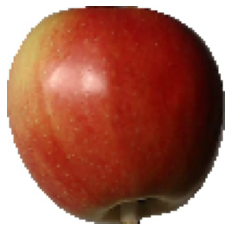

In [63]:
from keras.preprocessing import image

fruitlabel = np.array(target_labels)
test_fruit = image.load_img('/content/fruits-360/fruits-360-original-size/fruits-360-original-size/Test/apple_red_2/r0_143.jpg', target_size = (100,100))
test_fruit = image.img_to_array(test_fruit, dtype=np.uint8)
test_fruit = np.array(test_fruit)/255.0
prediction = model.predict(test_fruit[np.newaxis, ...])

print("- Precisión: ",np.max(prediction[0], axis=-1))
predicted_class = fruitlabel[np.argmax(prediction[0], axis=-1)]
print("- Clase: ",predicted_class,'\n')

plt.axis('off')
plt.imshow(test_fruit.squeeze());

- Precisión:  1.0
- Clase:  eggplant_violet_1 



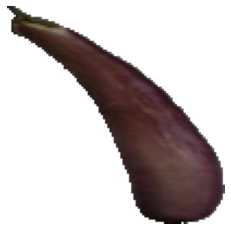

In [64]:
fruitlabel = np.array(target_labels)
test_fruit = image.load_img('/content/fruits-360/fruits-360-original-size/fruits-360-original-size/Test/eggplant_violet_1/r0_107.jpg', target_size = (100,100))
test_fruit = image.img_to_array(test_fruit, dtype=np.uint8)
test_fruit = np.array(test_fruit)/255.0
prediction = model.predict(test_fruit[np.newaxis, ...])

print("- Precisión: ",np.max(prediction[0], axis=-1))
predicted_class = fruitlabel[np.argmax(prediction[0], axis=-1)]
print("- Clase: ",predicted_class,'\n')

plt.axis('off')
plt.imshow(test_fruit.squeeze());

In [60]:
model =  tf.keras.models.load_model('/content/fruits_cnn.h5')
test_genertaor = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225) #  reflejará el 100% del preprocesamiento que se usó durante el entrenamiento del modelo preentrenado.

test_prec = test_genertaor.flow_from_directory(TEST_PATH,target_size=(100,100),shuffle = True)
loss,acc = model.evaluate(test_prec,verbose=2)

Found 3110 images belonging to 24 classes.
98/98 - 26s - loss: 0.2948 - accuracy: 0.8961 - 26s/epoch - 269ms/step
